This script generates a bar plot using data from a CSV file. The plot compares HypBO to different methods and their performance on various functions.

The script performs the following steps:

1. Reads the data from the CSV files.
2. Prepares the data by dropping unnecessary columns and setting the index.
3. Reorders the columns based on a predefined order.
4. Renames columns for better readability.
5. Defines bar positions and width.
6. Creates the plot by plotting each set of bars.
7. Sets the plot settings such as title, labels, and legend.
8. Displays the plot.


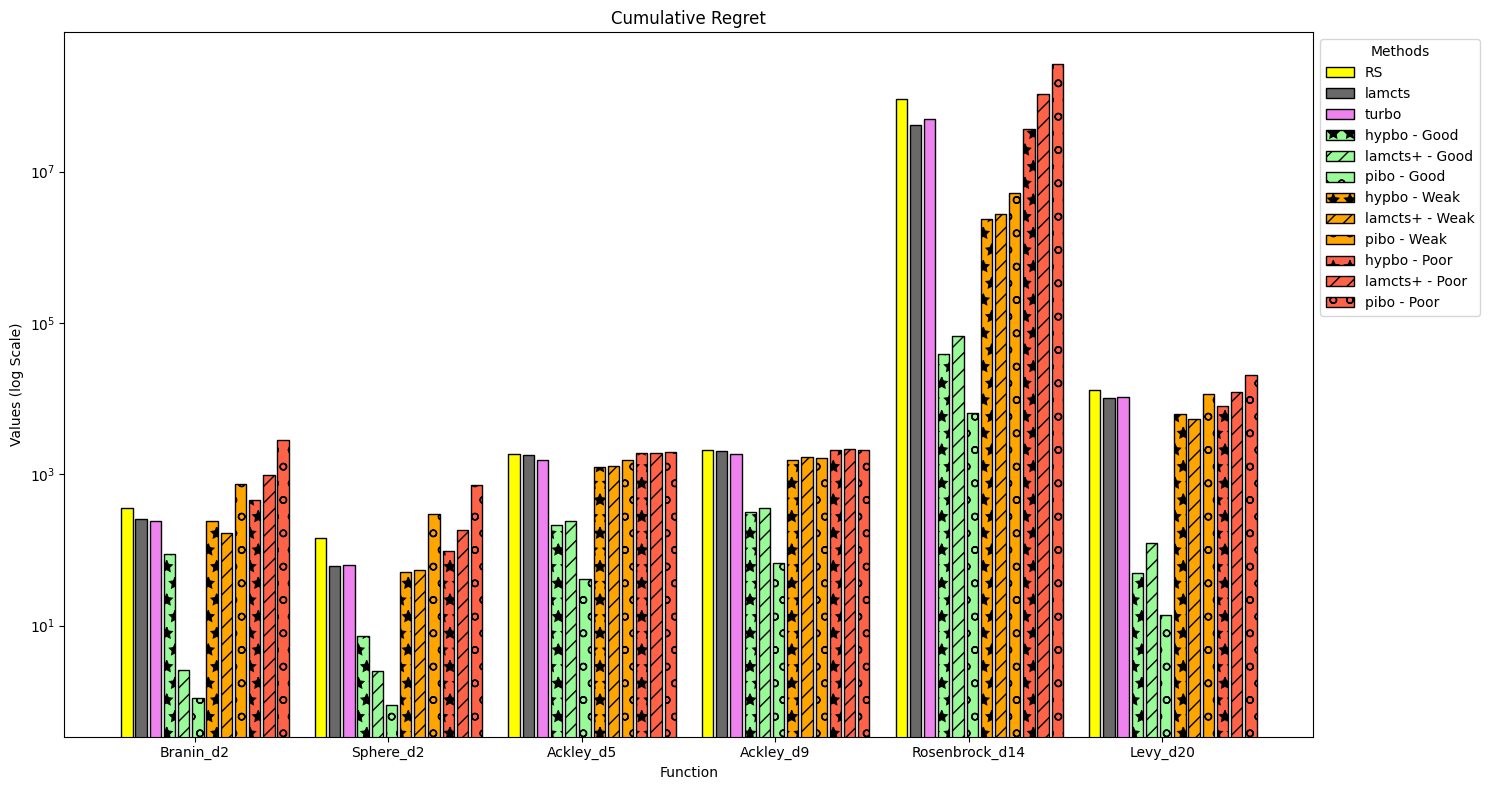

In [2]:
from calendar import c
import matplotlib.pyplot as plt
import pandas as pd
import os

single_hypothesis = True  # Set to True to plot the single hypothesis results.

# Read the data from the csv files.
file_path = os.path.join('data', 'hypbo_and_baselines', 'regret_cum.csv')
data = pd.read_csv(file_path)   # Regret data.
std_file_path = os.path.join(
    'data', 'hypbo_and_baselines', 'regret_std_cum.csv')
std_data = pd.read_csv(std_file_path)    # Standard deviation data.

# Preparing the data.
data = data.drop(data.columns[0], axis=1)  # Drop the first unnamed column.
# Rename certan columns.
data = data.rename(columns={'random_search - No Hypothesis': 'RS'})
data = data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})
data = data.rename(columns={'turbo - No Hypothesis': 'turbo'})
std_data = std_data.rename(columns={'random_search - No Hypothesis': 'RS'})
std_data = std_data.rename(columns={'lamcts - No Hypothesis': 'lamcts'})
std_data = std_data.rename(columns={'turbo - No Hypothesis': 'turbo'})

# Order of the columns to keep in the plot.
ordered_columns = [
    ('RS', 'yellow'),
    ('lamcts', 'dimgrey'),
    ('turbo', 'violet'),
]
# Add the relevant columns for the single or mixed hypothesis results.
if single_hypothesis:
    ordered_columns += [
        ('hypbo - Good', 'palegreen'),
        ('lamcts+ - Good', 'palegreen'),
        ('pibo - Good', 'palegreen'),
        ('hypbo - Weak', 'orange'),
        ('lamcts+ - Weak', 'orange'),
        ('pibo - Weak', 'orange'),
        ('hypbo - Poor', 'tomato'),
        ('lamcts+ - Poor', 'tomato'),
        ('pibo - Poor', 'tomato'),
    ]
else:
    ordered_columns += [
        ('hypbo - Poor_Good', 'skyblue'),
        ('lamcts+ - Good_Poor', 'skyblue'),
        ('hypbo - Weak_Good', 'palegreen'),
        ('lamcts+ - Good_Weak', 'palegreen'),
        ('hypbo - Poor_Weak', 'orange'),
        ('lamcts+ - Weak_Poor', 'orange')
    ]
# Unzip the ordered columns and colors.
ordered_columns, colors = zip(*ordered_columns)
ordered_columns = list(ordered_columns)
colors = list(colors)

# Drop columns that are not in the ordered columns.
for column in data.columns:
    if column not in ordered_columns and column != 'Function':
        data = data.drop(column, axis=1)
        std_data = std_data.drop(column, axis=1)
data = data.set_index('Function')  # Set 'Function' as index.
std_data = std_data.set_index('Function')  # Set 'Function' as index.

# Reorder the data with sorted columns.
data = data[ordered_columns]
std_data = std_data[ordered_columns]

# Define bar positions and width.
bar_width = 0.7 / len(data.columns)
bar_positions = {}

# Creating the plot.
plt.figure(figsize=(15, 8))
ax = plt.gca()
ax.set_yscale('log')    # Set log scale on the y axis.

# Plot each set of bars
space_in_pixels = 1.5  # The desired space between groups of bars, in pixels
dpi = plt.gcf().dpi  # Get the figure's resolution in dots per inch
space = space_in_pixels / dpi  # Convert pixels to coordinates
for i, (method, color) in enumerate(zip(data.columns, colors)):
    hatch = '//' if 'lamcts+' in method else (
        'o' if 'pibo' in method else ('*' if 'hypbo' in method else None))
    bar_position_with_space = [
        x + (bar_width + space) * i for x in range(len(data))]
    plt.bar(bar_position_with_space, data[method],
            width=bar_width, label=method, color=color, hatch=hatch,
            edgecolor='black', linewidth=1,  # Bar border
            # yerr=std_data[method], capsize=5  # Uncomment to add error bars
            )

# Final plot settings
title = 'Simple Regret' if single_hypothesis else 'Simple Regret (Mixed Hypothesis)'
title = title.replace('Simple', 'Cumulative') if 'cum' in file_path else title
plt.title(title)
plt.ylabel(f'Values ({ax.get_yscale()} Scale)')
plt.xlabel('Function')
plt.xticks([r + len(data.columns) // 2 * bar_width for r in range(len(data))],
           data.index, rotation=0)
plt.legend(title='Methods', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Wilcoxon with Bonferroni correction

## Single Hypothesis

### HypBO vs LAMCTS+ and piBO


In [3]:
from scipy.stats import wilcoxon
import pandas as pd
import os

# read data from csv file
file_path = os.path.join('data', 'hypbo_and_baselines',
                         'hypbo_and_baselines.csv')
data = pd.read_csv(file_path)

# Filter data for the last iteration only since we're interested in the final optimization outcome
last_iteration_data = data[data['iteration'] == 105]

# Function to perform Wilcoxon test with Bonferroni correction


def perform_wilcoxon_test(data, method1, method2, scenarios, alpha=0.05):
    results = {}
    for scenario in scenarios:
        # Filter data for the specific scenario
        data_scenario = data[data['scenario'] == scenario]

        # Extract values for both methods
        values_method1 = data_scenario[data_scenario['method']
                                       == method1]['value']
        values_method2 = data_scenario[data_scenario['method']
                                       == method2]['value']

        # Perform Wilcoxon test
        stat, p = wilcoxon(values_method1, values_method2)

        # Apply Bonferroni correction
        corrected_alpha = alpha / len(scenarios)
        print(f'Corrected alpha for {scenario}: {corrected_alpha}')

        results[scenario] = {
            'statistic': stat,
            'p-value': p,
            'significant': p < corrected_alpha
        }
    return results


# Scenarios to test
scenarios = ['Good', 'Poor', 'Weak']

# Perform Wilcoxon tests for HypBO vs LAMCTS+ and HypBO vs piBO under the same hypothesis scenarios
print('HypBO VS LAMCTS+')
results_hypbo_vs_lamcts = perform_wilcoxon_test(
    last_iteration_data, 'hypbo', 'lamcts+', scenarios)

print('HypBO VS piBO')
results_hypbo_vs_pibo = perform_wilcoxon_test(
    last_iteration_data, 'hypbo', 'pibo', scenarios)

results_hypbo_vs_lamcts, results_hypbo_vs_pibo

HypBO VS LAMCTS+
Corrected alpha for Good: 0.016666666666666666
Corrected alpha for Poor: 0.016666666666666666
Corrected alpha for Weak: 0.016666666666666666
HypBO VS piBO
Corrected alpha for Good: 0.016666666666666666
Corrected alpha for Poor: 0.016666666666666666
Corrected alpha for Weak: 0.016666666666666666


({'Good': {'statistic': 7.0, 'p-value': 0.5625, 'significant': False},
  'Poor': {'statistic': 8.0, 'p-value': 0.6875, 'significant': False},
  'Weak': {'statistic': 10.0, 'p-value': 1.0, 'significant': False}},
 {'Good': {'statistic': 7.0, 'p-value': 0.5625, 'significant': False},
  'Poor': {'statistic': 3.0, 'p-value': 0.15625, 'significant': False},
  'Weak': {'statistic': 1.0, 'p-value': 0.0625, 'significant': False}})

### HypBO vs RS, TuRBO and LAMCTS


In [4]:
from scipy.stats import wilcoxon

# Filtering the data for the relevant methods and hypothesis mixtures
relevant_methods = ['lamcts', 'turbo', 'random_search']
hypothesis_mixtures = ['Good', 'Weak', 'Poor']

# Preparing a dictionary to store the results
wilcoxon_results = {}

# Performing Wilcoxon tests for each combination of hypothesis mixture and baseline method
for hypothesis in hypothesis_mixtures:
    hypbo_data = data[(data['method'] == 'hypbo') &
                      (data['scenario'] == hypothesis)]
    for baseline in relevant_methods:
        baseline_data = data[data['method'] == baseline]

        # Assuming the same number of iterations for hypbo and baseline methods for each function
        # Calculating the Wilcoxon test for each function
        for func in data['func_name'].unique():
            hypbo_func_data = hypbo_data[hypbo_data['func_name']
                                         == func]['value']
            baseline_func_data = baseline_data[baseline_data['func_name']
                                               == func]['value']

            # Perform Wilcoxon test if both datasets are non-empty
            if not hypbo_func_data.empty and not baseline_func_data.empty:
                stat, p_value = wilcoxon(hypbo_func_data, baseline_func_data)
                key = (hypothesis, baseline, func)
                wilcoxon_results[key] = p_value

# Applying Bonferroni correction
total_tests = len(wilcoxon_results)
adjusted_alpha = 0.05 / total_tests

# Marking results as significant or not
significant_results = {
    key: p_value < adjusted_alpha for key, p_value in wilcoxon_results.items()}

significant_results, adjusted_alpha

({('Good', 'lamcts', 'Ackley_d5'): True,
  ('Good', 'lamcts', 'Ackley_d9'): True,
  ('Good', 'lamcts', 'Branin_d2'): True,
  ('Good', 'lamcts', 'Levy_d20'): True,
  ('Good', 'lamcts', 'Rosenbrock_d14'): True,
  ('Good', 'lamcts', 'Sphere_d2'): True,
  ('Good', 'turbo', 'Ackley_d5'): True,
  ('Good', 'turbo', 'Ackley_d9'): True,
  ('Good', 'turbo', 'Branin_d2'): True,
  ('Good', 'turbo', 'Levy_d20'): True,
  ('Good', 'turbo', 'Rosenbrock_d14'): True,
  ('Good', 'turbo', 'Sphere_d2'): True,
  ('Good', 'random_search', 'Ackley_d5'): True,
  ('Good', 'random_search', 'Ackley_d9'): True,
  ('Good', 'random_search', 'Branin_d2'): True,
  ('Good', 'random_search', 'Levy_d20'): True,
  ('Good', 'random_search', 'Rosenbrock_d14'): True,
  ('Good', 'random_search', 'Sphere_d2'): True,
  ('Weak', 'lamcts', 'Ackley_d5'): True,
  ('Weak', 'lamcts', 'Ackley_d9'): True,
  ('Weak', 'lamcts', 'Branin_d2'): True,
  ('Weak', 'lamcts', 'Levy_d20'): True,
  ('Weak', 'lamcts', 'Rosenbrock_d14'): True,
  ('W

Aggregating the data for hypbo with each hypothesis and for each baseline method.


In [5]:
wilcoxon_aggregated_results = {}

for hypothesis in hypothesis_mixtures:
    hypbo_aggregated_data = data[(data['method'] == 'hypbo') & (
        data['scenario'] == hypothesis)]['value']

    for baseline in relevant_methods:
        baseline_aggregated_data = data[data['method'] == baseline]['value']

        # Perform Wilcoxon test if both datasets are non-empty
        if not hypbo_aggregated_data.empty and not baseline_aggregated_data.empty:
            stat, p_value = wilcoxon(
                hypbo_aggregated_data, baseline_aggregated_data)
            key = (hypothesis, baseline)
            wilcoxon_aggregated_results[key] = p_value

# Applying Bonferroni correction
total_tests = len(wilcoxon_aggregated_results)
adjusted_alpha_aggregated = 0.05 / total_tests

print('Adjusted alpha:', adjusted_alpha_aggregated)
# Marking results as significant or not
significant_aggregated_results = {
    key: p_value < adjusted_alpha_aggregated for key, p_value in wilcoxon_aggregated_results.items()}

significant_aggregated_results, adjusted_alpha_aggregated

Adjusted alpha: 0.005555555555555556


({('Good', 'lamcts'): True,
  ('Good', 'turbo'): True,
  ('Good', 'random_search'): True,
  ('Weak', 'lamcts'): True,
  ('Weak', 'turbo'): True,
  ('Weak', 'random_search'): True,
  ('Poor', 'lamcts'): False,
  ('Poor', 'turbo'): True,
  ('Poor', 'random_search'): True},
 0.005555555555555556)

## Mixed Hypotheses

### HypBO VS LAMCTS+


In [6]:
import pandas as pd

# read data from csv file
file_path = os.path.join('data', 'hypbo_and_baselines',
                         'hypbo_and_baselines.csv')
data = pd.read_csv(file_path)

# Filter data for the last iteration only since we're interested in the final optimization outcome
last_iteration_data = data[data['iteration'] == 105]

# Scenarios to test
scenarios = ['Good_Poor', 'Good_Weak', 'Weak_Poor']

# Perform Wilcoxon tests for HypBO vs LAMCTS+ and HypBO vs piBO under the same hypothesis scenarios
print('HypBO VS LAMCTS+')
results_hypbo_vs_lamcts = perform_wilcoxon_test(
    last_iteration_data, 'hypbo', 'lamcts+', scenarios)

results_hypbo_vs_lamcts

HypBO VS LAMCTS+
Corrected alpha for Good_Poor: 0.016666666666666666
Corrected alpha for Good_Weak: 0.016666666666666666
Corrected alpha for Weak_Poor: 0.016666666666666666


{'Good_Poor': {'statistic': 3.0, 'p-value': 0.15625, 'significant': False},
 'Good_Weak': {'statistic': 3.0, 'p-value': 0.15625, 'significant': False},
 'Weak_Poor': {'statistic': 6.0, 'p-value': 0.4375, 'significant': False}}

### HypBO vs RS, TuRBO and LAMCTS


In [7]:
# Filtering the data for the relevant methods and hypothesis mixtures
relevant_methods = ['lamcts', 'turbo', 'random_search']
hypothesis_mixtures = ['Good_Poor', 'Good_Weak', 'Weak_Poor']

# Preparing a dictionary to store the results
wilcoxon_results = {}

# Performing Wilcoxon tests for each combination of hypothesis mixture and baseline method
for hypothesis in hypothesis_mixtures:
    hypbo_data = data[(data['method'] == 'hypbo') &
                      (data['scenario'] == hypothesis)]
    for baseline in relevant_methods:
        baseline_data = data[data['method'] == baseline]

        # Assuming the same number of iterations for hypbo and baseline methods for each function
        # Calculating the Wilcoxon test for each function
        for func in data['func_name'].unique():
            hypbo_func_data = hypbo_data[hypbo_data['func_name']
                                         == func]['value']
            baseline_func_data = baseline_data[baseline_data['func_name']
                                               == func]['value']

            # Perform Wilcoxon test if both datasets are non-empty
            if not hypbo_func_data.empty and not baseline_func_data.empty:
                stat, p_value = wilcoxon(hypbo_func_data, baseline_func_data)
                key = (hypothesis, baseline, func)
                wilcoxon_results[key] = p_value

# Applying Bonferroni correction
total_tests = len(wilcoxon_results)
adjusted_alpha = 0.05 / total_tests

# Marking results as significant or not
significant_results = {
    key: p_value < adjusted_alpha for key, p_value in wilcoxon_results.items()}

significant_results, adjusted_alpha

({('Good_Poor', 'lamcts', 'Ackley_d5'): True,
  ('Good_Poor', 'lamcts', 'Ackley_d9'): True,
  ('Good_Poor', 'lamcts', 'Branin_d2'): True,
  ('Good_Poor', 'lamcts', 'Levy_d20'): True,
  ('Good_Poor', 'lamcts', 'Rosenbrock_d14'): True,
  ('Good_Poor', 'lamcts', 'Sphere_d2'): True,
  ('Good_Poor', 'turbo', 'Ackley_d5'): True,
  ('Good_Poor', 'turbo', 'Ackley_d9'): True,
  ('Good_Poor', 'turbo', 'Branin_d2'): True,
  ('Good_Poor', 'turbo', 'Levy_d20'): True,
  ('Good_Poor', 'turbo', 'Rosenbrock_d14'): True,
  ('Good_Poor', 'turbo', 'Sphere_d2'): True,
  ('Good_Poor', 'random_search', 'Ackley_d5'): True,
  ('Good_Poor', 'random_search', 'Ackley_d9'): True,
  ('Good_Poor', 'random_search', 'Branin_d2'): True,
  ('Good_Poor', 'random_search', 'Levy_d20'): True,
  ('Good_Poor', 'random_search', 'Rosenbrock_d14'): True,
  ('Good_Poor', 'random_search', 'Sphere_d2'): True,
  ('Good_Weak', 'lamcts', 'Ackley_d5'): True,
  ('Good_Weak', 'lamcts', 'Ackley_d9'): True,
  ('Good_Weak', 'lamcts', 'Brani

In [8]:
# Aggregating the data for hypbo with each hypothesis and for each baseline method
wilcoxon_aggregated_results = {}

for hypothesis in hypothesis_mixtures:
    hypbo_aggregated_data = data[(data['method'] == 'hypbo') & (
        data['scenario'] == hypothesis)]['value']

    for baseline in relevant_methods:
        baseline_aggregated_data = data[data['method'] == baseline]['value']

        # Perform Wilcoxon test if both datasets are non-empty
        if not hypbo_aggregated_data.empty and not baseline_aggregated_data.empty:
            stat, p_value = wilcoxon(
                hypbo_aggregated_data, baseline_aggregated_data)
            key = (hypothesis, baseline)
            wilcoxon_aggregated_results[key] = p_value

# Applying Bonferroni correction
total_tests = len(wilcoxon_aggregated_results)
adjusted_alpha_aggregated = 0.05 / total_tests

print('Adjusted alpha:', adjusted_alpha_aggregated)
# Marking results as significant or not
significant_aggregated_results = {
    key: p_value < adjusted_alpha_aggregated for key, p_value in wilcoxon_aggregated_results.items()}

significant_aggregated_results, adjusted_alpha_aggregated

Adjusted alpha: 0.005555555555555556


({('Good_Poor', 'lamcts'): True,
  ('Good_Poor', 'turbo'): True,
  ('Good_Poor', 'random_search'): True,
  ('Good_Weak', 'lamcts'): True,
  ('Good_Weak', 'turbo'): True,
  ('Good_Weak', 'random_search'): True,
  ('Weak_Poor', 'lamcts'): True,
  ('Weak_Poor', 'turbo'): True,
  ('Weak_Poor', 'random_search'): True},
 0.005555555555555556)